In [48]:
!pip install opencv-python matplotlib imageio gdown tensorflow

DEFINING SOME FUNCTIONS WHICH ARE NEEDED LATER


In [49]:
#load video frames, process them, and prepare the data for input in the lip reading model
import os
import cv2
import numpy as np



In [51]:
#Libraries for plotting and images
from matplotlib import pyplot as plt
import imageio

In [52]:
pip install --upgrade scipy


Note: you may need to restart the kernel to use updated packages.


DATA LOADING FUNCTIONS

In [53]:
def videoloading(path:str)->List[float]:
    capt=cv2.VideoCapture(path)
    frames=[]
    for _ in range(int(capt.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame=capt.read()
        grayframe=tf.image.rgb_to_grayscale(frame)
        crop_frame=(grayframe[190:236,80:220,:])
        frames.append(crop_frame)
    capt.release()

    mean_value=tf.math.reduce_mean(frames)
    std_dev=tf.math.reduce_std(tf.cast(frames,tf.float32))
    return tf.cast((frames-mean_value),tf.float32)/std_dev


In [54]:
letterset=[v for v in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]


In [55]:
letterset

['a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [56]:
#Converting 
charnum=tf.keras.layers.StringLookup(vocabulary=letterset,oov_token="")
numchar=tf.keras.layers.StringLookup(
    vocabulary=charnum.get_vocabulary(),oov_token="",invert=True
)

print(
    f"The vocabulary is {charnum.get_vocabulary()}"
    f"(size={charnum.vocabulary_size()})"
)

The vocabulary is ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '](size=40)


In [57]:
charnum(['h','a','r','s','h'])

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 8,  1, 18, 19,  8])>

In [58]:
def captionsloading(path: str) -> tf.Tensor:
    with open(path, 'r') as f:
        lines = f.readlines()

    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens.extend([' ', line[2]])

    tokens_string = tf.strings.join(tokens)
    split_tokens = tf.strings.unicode_split(tokens_string, input_encoding='UTF-8')
    result = charnum(split_tokens)
    result = tf.reshape(result, (-1))
    return result


In [59]:
def data_loading(path:str):
    path=bytes.decode(path.numpy())

    file_label=path.split('/')[-1].split('.')[0]
  
    #THIS TO BE USED IF CODE IS RAN ON GOOGLE COLAB
    #file_label=path.split('\\')[-1].split('.')[0] Reserved if the program is run in google colab
  
    #Defining the paths for videos and alignments according to the file name
    video_path=os.path.join('/','kaggle','input','lipreading-new','data','s1',f'{file_label}.mpg')
    alignment_path=os.path.join('/','kaggle','input','lipreading-new','data','alignments','s1',f'{file_label}.align')
  
  
    frames=videoloading(video_path)
    captions=captionsloading(alignment_path)

    return frames,captions

In [60]:
video_directorypath='/kaggle/input/lipreading-new/data/s1/bbaf2n.mpg.'

In [61]:
#To extract the name of the file from the tensors
tf.convert_to_tensor(video_directorypath).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbaf2n'

In [62]:
frames, captions = data_loading(tf.convert_to_tensor(video_directorypath))

In [63]:
#Function to decode if the predictions can be converted into normal text

captions_np = captions.numpy()
char_reps_tensor = numchar(captions_np)
char_reps_np = char_reps_tensor.numpy()
decoded_strings = [bytes.decode(h) for h in char_reps_np]
print(decoded_strings)


[' ', 'b', 'i', 'n', ' ', 'b', 'l', 'u', 'e', ' ', 'a', 't', ' ', 'f', ' ', 't', 'w', 'o', ' ', 'n', 'o', 'w']


In [64]:
def mapping(path:str)->List[str]:
  result=tf.py_function(data_loading,[path],(tf.float32,tf.int64))
  return result

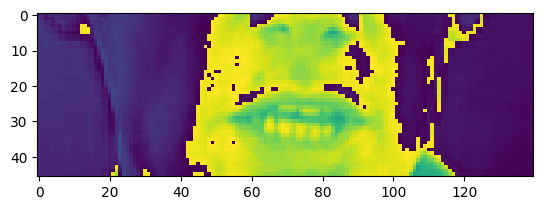

In [65]:
 #0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][16])

In [66]:
#CHECKING VIDEOS FOR ERRORS
import cv2
import os

# Directory containing the video files
video_directory = '/kaggle/input/lipreading-new/data/s1'
video_extensions = ['.mp4']

def check_video_for_errors(video_path):
    try:
        
        cap = cv2.VideoCapture(video_path)

        while cap.isOpened():
            ret, frame = cap.read()

            # Break the loop if the video ends
            if not ret:
                break

           
        cap.release()

    except Exception as e:
        
        print(f"Error in {video_path}: {str(e)}")


for root, _, files in os.walk(video_directory):
    for file in files:
        # Check if the file has a video extension
        if any(file.endswith(ext) for ext in video_extensions):
            video_path = os.path.join(root, file)
            check_video_for_errors(video_path)


CREATE DATA PIPELINE


In [67]:
from matplotlib import pyplot as plt

In [68]:
videoinfo = tf.data.Dataset.list_files('/kaggle/input/lipreading-new/data/s1/*.mpg')







In [70]:
videoinfo = videoinfo.map(mapping)

In [71]:
videoinfo = videoinfo.padded_batch(2, padded_shapes=([75,None,None,None],[40]))

In [72]:
videoinfo = videoinfo.prefetch(tf.data.AUTOTUNE)

In [73]:
# Added for split in training and testing
training = videoinfo.take(450)
testing = videoinfo.skip(450)

In [74]:
len(testing)

43

In [75]:
len(training)

450

In [76]:
videoinfo

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [77]:
testing

<_SkipDataset element_spec=(TensorSpec(shape=(None, 75, None, None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 40), dtype=tf.int64, name=None))>

In [78]:
videoinfo.as_numpy_iterator().next()

(array([[[[[ 1.5151916 ],
           [ 1.5151916 ],
           [ 1.4791156 ],
           ...,
           [ 0.3968359 ],
           [ 0.3968359 ],
           [ 0.3968359 ]],
 
          [[ 1.4430397 ],
           [ 1.4430397 ],
           [ 1.4069636 ],
           ...,
           [ 0.3968359 ],
           [ 0.3968359 ],
           [ 0.3968359 ]],
 
          [[ 1.4430397 ],
           [ 1.4430397 ],
           [ 1.3708876 ],
           ...,
           [ 0.43291187],
           [ 0.3246839 ],
           [ 0.3246839 ]],
 
          ...,
 
          [[ 1.0462037 ],
           [ 1.0462037 ],
           [ 1.0462037 ],
           ...,
           [ 0.        ],
           [ 0.        ],
           [ 0.        ]],
 
          [[ 1.0101278 ],
           [ 1.0101278 ],
           [ 1.0101278 ],
           ...,
           [ 9.163301  ],
           [ 9.163301  ],
           [ 9.163301  ]],
 
          [[ 1.0101278 ],
           [ 1.0101278 ],
           [ 0.9740517 ],
           ...,
           [ 9

In [79]:
frame, captions=videoinfo.as_numpy_iterator().next()

In [80]:
captions

array([[39, 12,  1, 25, 39,  7, 18,  5,  5, 14, 39, 23,  9, 20,  8, 39,
        13, 39, 19,  9, 24, 39, 14, 15, 23,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0],
       [39, 19,  5, 20, 39, 23,  8,  9, 20,  5, 39, 23,  9, 20,  8, 39,
        22, 39,  5,  9,  7,  8, 20, 39, 16, 12,  5,  1, 19,  5,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0]])

In [81]:
frame

array([[[[[ 1.6026441 ],
          [ 1.3681108 ],
          [ 1.2508441 ],
          ...,
          [ 0.31271103],
          [ 0.23453328],
          [ 0.23453328]],

         [[ 1.3681108 ],
          [ 1.3681108 ],
          [ 1.3290219 ],
          ...,
          [ 0.31271103],
          [ 0.23453328],
          [ 0.23453328]],

         [[ 1.6417329 ],
          [ 1.6417329 ],
          [ 1.5244663 ],
          ...,
          [ 0.31271103],
          [ 0.27362216],
          [ 0.27362216]],

         ...,

         [[ 1.1726664 ],
          [ 1.0944886 ],
          [ 1.0944886 ],
          ...,
          [ 0.03908888],
          [ 0.        ],
          [ 9.967665  ]],

         [[ 1.0944886 ],
          [ 1.0944886 ],
          [ 1.0944886 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 9.967665  ]],

         [[ 1.0944886 ],
          [ 1.0944886 ],
          [ 1.0944886 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          

In [82]:
len(frame)

2

In [83]:
sample = videoinfo.as_numpy_iterator()

In [84]:
val = sample.next();
val[0]

array([[[[[1.2565647 ],
          [1.1129574 ],
          [0.718037  ],
          ...,
          [0.32311666],
          [0.32311666],
          [0.32311666]],

         [[1.2565647 ],
          [1.1488591 ],
          [0.6103315 ],
          ...,
          [0.32311666],
          [0.32311666],
          [0.32311666]],

         [[1.3283684 ],
          [1.3642703 ],
          [1.184761  ],
          ...,
          [0.39492035],
          [0.3590185 ],
          [0.3590185 ]],

         ...,

         [[1.0411537 ],
          [1.0411537 ],
          [1.0411537 ],
          ...,
          [0.10770555],
          [0.0718037 ],
          [0.0718037 ]],

         [[1.0052518 ],
          [1.0052518 ],
          [1.0052518 ],
          ...,
          [0.10770555],
          [0.0718037 ],
          [0.0718037 ]],

         [[1.0052518 ],
          [1.0052518 ],
          [1.0052518 ],
          ...,
          [0.10770555],
          [0.0718037 ],
          [0.0718037 ]]],


        [[[1.2924

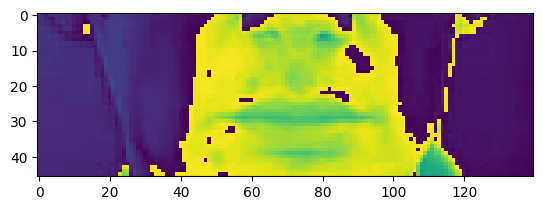

In [85]:
plt.imshow(val[0][0][1])

In [86]:
sample_tensor=tf.strings.reduce_join([numchar(word) for word in val[1][0]])
sample_tensor

<tf.Tensor: shape=(), dtype=string, numpy=b' set white at b nine again'>

In [87]:
tf.strings.reduce_join([numchar(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b' set white at b nine again'>

In [88]:
tf.config.list_physical_devices('GPU')
physical_devices=tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
    pass

DEEP NEURAL NETWORK DESIGN


In [89]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [90]:
videoinfo.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [91]:
lipreadingmodel = Sequential()
lipreadingmodel.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
lipreadingmodel.add(Activation('relu'))
lipreadingmodel.add(MaxPool3D((1,2,2)))

lipreadingmodel.add(Conv3D(256, 3, padding='same'))
lipreadingmodel.add(Activation('relu'))
lipreadingmodel.add(MaxPool3D((1,2,2)))

lipreadingmodel.add(Conv3D(75, 3, padding='same'))
lipreadingmodel.add(Activation('relu'))
lipreadingmodel.add(MaxPool3D((1,2,2)))

lipreadingmodel.add(TimeDistributed(Flatten()))

lipreadingmodel.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
lipreadingmodel.add(Dropout(.5))

lipreadingmodel.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
lipreadingmodel.add(Dropout(.5))

lipreadingmodel.add(Dense(charnum.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [92]:
lipreadingmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_3 (Activation)   (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 75, 23, 70, 128)  0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_4 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                  

In [93]:
 #test123 =lipreadingmodel.predict(val[0])

Training And Testing

In [95]:
def learning_scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [96]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [97]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.lipreadingmodel.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(predictions123, [75,75], greedy=False)[0][0].numpy()
        for x in range(len()):
            print('Original:', tf.strings.reduce_join(numchar(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(numchar(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [98]:

lipreadingmodel.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [99]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True)

In [100]:
s_callback = LearningRateScheduler(learning_scheduler)


In [101]:
ex_callback = ProduceExample(testing)

In [102]:
#NEW LINE ADDED
import tensorflow as tf

# Keeping track of vaiables using this
num_samples = 0
sample_shape = None


for sample in training:
    num_samples += 1
    if sample_shape is None:
        sample_shape = sample[0].shape  # Assuming the first element is a feature
    else:
        sample_shape = tf.TensorShape([max(sample_shape[i], sample[0].shape[i]) for i in range(len(sample_shape))])

# Convert the sample_shape to a tuple (if needed)
sample_shape_tuple = tuple(sample_shape.as_list())

# Print the inferred shape information
print("Number of samples:", num_samples)
print("Inferred sample shape:", sample_shape_tuple)


[mpeg1video @ 0x79347022f7c0] ac-tex damaged at 22 17
[mpeg1video @ 0x79347022f7c0] Warning MVs not available


Number of samples: 450
Inferred sample shape: (2, 75, 46, 140, 1)


In [103]:
#lipreadingmodel.fit(training, validation_data=testing, epochs=92, callbacks=[checkpoint_callback, s_callback, ex_callback])


In [104]:
#from tensorflow import keras

#loaded_model = keras.models.load_model('/kaggle/working/my_lipreading_model_12.h5')

In [105]:
model_exprediction = lipreadingmodel.predict(val[0])

1/1 [==============================] - 5s 5s/step


In [106]:
lipreadingmodel.input_shape

(None, 75, 46, 140, 1)

In [107]:
lipreadingmodel.output_shape


(None, 75, 41)

PREDICTION MAKING

In [108]:
#CHECK IF MODEL IS SUCCESSFULLY IMPORTED
#In kaggle directory
import os
file_path = "/kaggle/input/checkpoints/models/checkpoint"  
if os.path.exists(file_path):
    print(f"The file '{file_path}' exists.")
else:
    print(f"The file '{file_path}' does not exist.")


The file '/kaggle/input/checkpoints/models/checkpoint' does not exist.


In [109]:
lipreadingmodel.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)

In [110]:
lipreadingmodel.load_weights('/kaggle/input/checkpoint2/checkpoint')


In [111]:
test_data = testing.as_numpy_iterator()

In [112]:
test_sample = test_data.next()

[mpeg1video @ 0x7938a43e1580] ac-tex damaged at 22 17
[mpeg1video @ 0x7938a43e1580] Warning MVs not available


In [113]:
preditctions123 = lipreadingmodel.predict(sample[0])

1/1 [==============================] - 2s 2s/step


In [114]:
print( 'ORIGNIAL_TEXT')
[tf.strings.reduce_join([numchar(word) for word in sentence]) for sentence in sample[1]]

ORIGNIAL_TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b' lay red at e two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b' set green by c six now'>]

In [115]:
decoded_text = tf.keras.backend.ctc_decode(preditctions123, input_length=[75,75], greedy=True)[0][0].numpy()

In [116]:
print('~'*100, 'PREDICTION_TEXT')
[tf.strings.reduce_join([numchar(word) for word in sentence]) for sentence in decoded_text]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTION_TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'lay red at e two now'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set green by c six now'>]

TEST ON VIDEO

In [117]:
sample = data_loading(tf.convert_to_tensor('/kaggle/input/lipreading-new/data/s1/bbaf3s.mpg'))

In [118]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([numchar(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b' bin blue at f three soon'>]

In [119]:
predictions123 = lipreadingmodel.predict(tf.expand_dims(sample[0], axis=0))


1/1 [==============================] - 1s 507ms/step


In [120]:
frames, captions = data_loading(tf.convert_to_tensor(video_directorypath))

In [121]:
decoded_text = tf.keras.backend.ctc_decode(predictions123, input_length=[75], greedy=True)[0][0].numpy()

In [122]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([numchar(word) for word in sentence]) for sentence in decoded_text]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at j three soon'>]

In [123]:
pip install --upgrade scipy numpy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 58.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.2 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.2 which 

In [124]:
#import nltk
import numpy as np


# Calculate Word Error Rate (WER)
def calculate_wer(reference, hypothesis):
    reference_tokens = reference.split()
    hypothesis_tokens = hypothesis.split()

    if len(reference_tokens) == 0:
        return len(hypothesis_tokens)
    
    dp = np.zeros((len(reference_tokens) + 1, len(hypothesis_tokens) + 1), dtype=int)
    
    for i in range(len(reference_tokens) + 1):
        dp[i][0] = i
    for j in range(len(hypothesis_tokens) + 1):
        dp[0][j] = j
    
    for i in range(1, len(reference_tokens) + 1):
        for j in range(1, len(hypothesis_tokens) + 1):
            cost = 0 if reference_tokens[i - 1] == hypothesis_tokens[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)
    
    return dp[len(reference_tokens)][len(hypothesis_tokens)] / len(reference_tokens)




In [125]:
# Calculate Character Error Rate (CER)
def calculate_cer(reference, hypothesis):
    ref_chars = list(reference)
    hypo_chars = list(hypothesis)

    if len(ref_chars) == 0:
        return len(hypo_chars)
    
    dp = np.zeros((len(ref_chars) + 1, len(hypo_chars) + 1), dtype=int)
    
    for i in range(len(ref_chars) + 1):
        dp[i][0] = i
    for j in range(len(hypo_chars) + 1):
        dp[0][j] = j
    
    for i in range(1, len(ref_chars) + 1):
        for j in range(1, len(hypo_chars) + 1):
            cost = 0 if ref_chars[i - 1] == hypo_chars[j - 1] else 1
            dp[i][j] = min(dp[i - 1][j] + 1, dp[i][j - 1] + 1, dp[i - 1][j - 1] + cost)
    
    return dp[len(ref_chars)][len(hypo_chars)] / len(ref_chars)

In [126]:
#Taking sample text to calculate scores:
reference_text = "this is a reference sentence"
hypothesis_text = "this is a hypothesis sentence"

wer_result =calculate_wer(reference_text, hypothesis_text)
cer_result =calculate_cer(reference_text, hypothesis_text)


print("WER Score:", wer_result)
print("CER Score:", cer_result)


WER Score: 0.2
CER Score: 0.32142857142857145


In [127]:
!pip install nltk

In [128]:
pip install --upgrade numpy


  Using cached numpy-1.26.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.7 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 1.26.2 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 11.0.0 which is incompatible.
cudf 23.8.0 requires pandas<1.6.0dev0,>=1.3, but you have pandas 2.0.2 

In [129]:
lipreadingmodel.load_weights('/kaggle/input/checkpoint2/checkpoint')

In [131]:
# Directory containing video files for processing
video_directory = '/kaggle/input/lipreading-last/data/Test'

total_wer = 0.0
total_cer = 0.0
total_videos = 0

# Counters for different categories for WER
videos_wer_zero = 0
videos_wer_between_0_and_2 = 0
videos_wer_greater_than_2 = 0

# Counters for different categories for CER
videos_cer_zero = 0
videos_cer_between_0_and_2 = 0
videos_cer_greater_than_2 = 0

# Loop through video files in the directory
for filename in os.listdir(video_directory):
    if filename.endswith('.mpg'):
        video_path = os.path.join(video_directory, filename)

        # Load data for the current video
        sample = data_loading(tf.convert_to_tensor(video_path))

        # Process real text
        real_text = tf.strings.reduce_join([numchar(word) for word in sample[1]]).numpy().decode()

        # Make predictions
        predictions123 = lipreadingmodel.predict(tf.expand_dims(sample[0], axis=0))
        input_length = min(75, len(sample[0]))
        decoded_text = tf.keras.backend.ctc_decode(predictions123, input_length=[input_length], greedy=True)[0][0].numpy()
        predicted_text = " " + tf.strings.reduce_join([numchar(word) for word in decoded_text]).numpy().decode()

        # Calculate WER and CER scores
        wer_score = calculate_wer(real_text, predicted_text)
        cer_score = calculate_cer(real_text, predicted_text)

        # Print the scores for the current video which is processed
        print("Video:", filename)
        print("Real Text:", real_text)
        print("Predicted Text:", predicted_text)
        print("WER Score:", wer_score)
        print("CER Score:", cer_score)
        print("~" * 100)  # Separator line

        # Increment total scores
        total_wer += wer_score
        total_cer += cer_score
        total_videos += 1

        # Categorize videos based on WER
        if wer_score == 0:
            videos_wer_zero += 1
        elif 0 < wer_score <= 2:
            videos_wer_between_0_and_2 += 1
        elif wer_score > 2:
            videos_wer_greater_than_2 += 1

        # Categorize videos based on CER
        if cer_score == 0:
            videos_cer_zero += 1
        elif 0 < cer_score <= 2:
            videos_cer_between_0_and_2 += 1
        elif cer_score > 2:
            videos_cer_greater_than_2 += 1

# Calculate averages
average_wer = total_wer / total_videos
average_cer = total_cer / total_videos

# Print category counts for WER
print("Videos with WER equal to 0:", videos_wer_zero)
print("Videos with 0 < WER <= 2:", videos_wer_between_0_and_2)
print("Videos with WER greater than 2:", videos_wer_greater_than_2)

# Print category counts for CER
print("Videos with CER equal to 0:", videos_cer_zero)
print("Videos with 0 < CER <= 2:", videos_cer_between_0_and_2)
print("Videos with CER greater than 2:", videos_cer_greater_than_2)

# Print averages
print("Average WER Score:", average_wer)
print("Average CER Score:", average_cer)
 
        


1/1 [==============================] - 0s 74ms/step
Video: pgwe7s.mpg
Real Text:  place green with e seven soon
Predicted Text:  place green with seven soon
WER Score: 0.16666666666666666
CER Score: 0.06666666666666667
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 73ms/step
Video: pwbq5s.mpg
Real Text:  place white by q five soon
Predicted Text:  place white by j five soon
WER Score: 0.16666666666666666
CER Score: 0.037037037037037035
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 73ms/step
Video: lbwe5s.mpg
Real Text:  lay blue with e five soon
Predicted Text:  lay blue with five soon
WER Score: 0.16666666666666666
CER Score: 0.07692307692307693
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 73ms/step

In [132]:
pip install --upgrade scikit-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 78.7 MB/s eta 0:00:0000:010:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
woodwork 0.26.0 requires numpy<1.25.0,>=1.22.0, but you have numpy 1.26.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


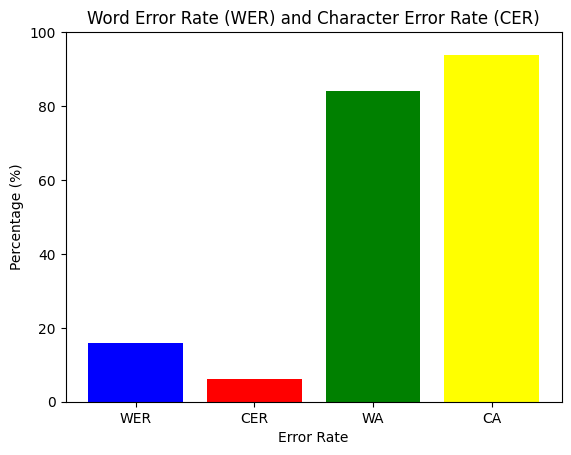

In [133]:
import matplotlib.pyplot as plt

wer = 15.8
cer = 6.2
word_accur=84.2
char_accur=93.8

# Multiply by 100 to represent percentages
wer_percent = wer 
cer_percent = cer 

labels = ['WER', 'CER','WA','CA']
values = [wer_percent, cer_percent,word_accur,char_accur]

plt.bar(labels, values, color=['blue', 'red','green','yellow'])

plt.xlabel('Error Rate')
plt.ylabel('Percentage (%)')
plt.title('Word Error Rate (WER) and Character Error Rate (CER)')

plt.ylim(0, 100)  # Set the y-axis limit to 0-100 for percentage representation

plt.show()



In [135]:
import os
import tensorflow as tf

# Directory containing video files for processing
video_directory = '/kaggle/input/lipreading-new/data/s1'

total_wer = 0.0
total_cer = 0.0
total_bleu = 0.0
total_videos = 0
error_videos = []

# List all video files in the directory
video_files = [filename for filename in os.listdir(video_directory) if filename.endswith('.mpg')]


# Loop through video files in the directory
for filename in video_files_to_process:
    video_path = os.path.join(video_directory, filename)
    
    try:
        # Load data for the current video
        sample = data_loading(tf.convert_to_tensor(video_path))
        
        # Process real text
        real_text = tf.strings.reduce_join([numchar(word) for word in sample[1]]).numpy().decode()
        
        # Make predictions
        predictions123 = lipreadingmodel.predict(tf.expand_dims(sample[0], axis=0))
        input_length = min(75, len(sample[0]))
        decoded_text = tf.keras.backend.ctc_decode(predictions123, input_length=[input_length], greedy=True)[0][0].numpy()
        predicted_text = " " + tf.strings.reduce_join([numchar(word) for word in decoded_text]).numpy().decode()
        
        # Calculate WER, CER, and BLEU scores
        wer_score = calculate_wer(real_text, predicted_text)
        cer_score = calculate_cer(real_text, predicted_text)
      
        # Print the scores for the current video which is processed
        print("Video:", filename)
        print("Real Text:", real_text)
        print("Predicted Text:", predicted_text)
        print("WER Score:", wer_score)
        print("CER Score:", cer_score)
        
        print("~" * 100)  # Separator line
        
        total_wer += wer_score
        total_cer += cer_score
        
        total_videos += 1
    
    except Exception as e:
        print(f"Error processing video {filename}: {str(e)}")
        error_videos.append(filename)

# Print the names of videos that caused errors
print("\nVideos with errors:")
print(error_videos)


1/1 [==============================] - 0s 75ms/step
Video: sban2n.mpg
Real Text:  set blue at n two now
Predicted Text:  set blue at n two now
WER Score: 0.0
CER Score: 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 73ms/step
Video: lriq6n.mpg
Real Text:  lay red in q six now
Predicted Text:  lay red in v six now
WER Score: 0.16666666666666666
CER Score: 0.047619047619047616
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 73ms/step
Video: pwic8n.mpg
Real Text:  place white in c eight now
Predicted Text:  place white in c eight now
WER Score: 0.0
CER Score: 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 73ms/step
Video: prax1a.mpg
Real Text:  place red at x one again
Predicted Text:  place red at 

In [136]:
numchar=tf.keras.layers.StringLookup(
    vocabulary=charnum.get_vocabulary(),oov_token="",invert=True
)

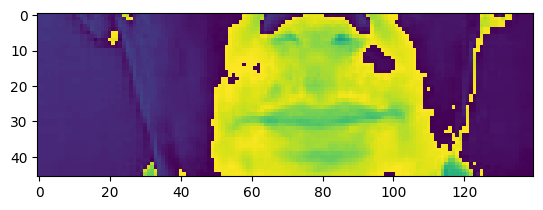

In [137]:
import numpy as np

def get_frames_for_word(word, video_path, alignment_path):
    frames = videoloading(video_path)
    captions = captionsloading(alignment_path)  

    decoded_captions = [numchar(caption) for caption in captions]

    word_indices = [i for i, caption in enumerate(decoded_captions) if word in caption.numpy().decode('utf-8')]

    frames_for_word = [frames[i] for i in word_indices]

    return frames_for_word


character_to_find = 'e'
video_path = '/kaggle/input/lipreading-new/data/s1/bbaf2n.mpg'  
alignment_path = '/kaggle/input/lipreading-new/data/alignments/s1/bbaf2n.align'  

frames_for_word = get_frames_for_word(character_to_find, video_path, alignment_path)


for frame in frames_for_word:
    plt.imshow(frame)
    plt.show()


In [138]:
# video_directorypath='/kaggle/input/new-dataset/New_Dataset/s10/s10/bbab8n.mpg'

# #To extract the name of the file from the tensors
# tf.convert_to_tensor(video_directorypath).numpy().decode('utf-8').split('/')[-1].split('.')[0]
# frames, captions = data_loading(tf.convert_to_tensor(video_directorypath))

# captions_np = captions.numpy()
# char_reps_tensor = numchar(captions_np)
# char_reps_np = char_reps_tensor.numpy()
# decoded_strings = [bytes.decode(h) for h in char_reps_np]
# print(decoded_strings)

# def mapping(path:str)->List[str]:
#   result=tf.py_function(data_loading,[path],(tf.float32,tf.int64))
#   return result

# plt.imshow(val[0][0][16])

# plt.imshow(val[0][0][1])

# sample_tensor=tf.strings.reduce_join([numchar(word) for word in val[1][0]])
# sample_tensor

# model_exprediction = lipreadingmodel.predict(val[0])

# decoded_text = tf.keras.backend.ctc_decode(preditctions123, input_length=[75,75], greedy=True)[0][0].numpy()

# print('~'*100, 'PREDICTION_TEXT')
# [tf.strings.reduce_join([numchar(word) for word in sentence]) for sentence in decoded_text]

In [139]:
import os

def check_directory(directory_path):
    if os.path.exists(directory_path):
        print(f"The directory '{directory_path}' exists.")
    else:
        print(f"The directory '{directory_path}' does not exist.")

# Example usage
directory_path = '/kaggle/input/new-dataset/New_Dataset/alignments/alignments/s10'
check_directory(directory_path)



The directory '/kaggle/input/new-dataset/New_Dataset/alignments/alignments/s10' does not exist.


In [140]:

def load_data_new(path: str):
    path = bytes.decode(path.numpy())
    file_label = path.split('/')[-1].split('.')[0]

    # Defining the paths for videos and alignments according to the file name
    video_path = os.path.join('/kaggle/input/lipdatasets/New_Dataset_final/s34.mpg_vcd/s34', f'{file_label}.mpg')
    alignment_path = os.path.join('/kaggle/input/lipdatasets/New_Dataset_final/s34/align', f'{file_label}.align')

    frames = videoloading(video_path)
    captions = captionsloading(alignment_path)

    return frames, captions


In [141]:
# # Directory path for the new dataset videos
# video_directorypath_new = '/kaggle/input/lipdatasets/New_Dataset_final/s34.mpg_vcd/s34/*.mpg'

# # Function to map paths to processed data for the new dataset
# def mapping_new(path: str) -> Tuple[tf.Tensor, tf.Tensor]:
#     mapped_vid = tf.py_function(load_data_new, [path], (tf.float32, tf.int64))
#     return mapped_vid


# # ... (continue with the rest of your existing code)

In [142]:
# Directory path for the new dataset videos
video_directorypath_new = '/kaggle/input/lipdatasets/New_Dataset_final/s34.mpg_vcd/s34/*.mpg'

# Function to map paths to processed data for the new dataset
def mapping_new(path: str):
    mapped_vid = tf.py_function(load_data_new, [path], (tf.float32, tf.int64))
    return mapped_vid





In [143]:
# # Create a dataset for the new videos
# videoinfo_new = tf.data.Dataset.list_files('/kaggle/input/lipdatasets/New_Dataset_final/s34.mpg_vcd/s34/*.mpg')
# videoinfo_new = videoinfo_new.map(mapping_new)
# videoinfo_new = videoinfo_new.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
# videoinfo_new = videoinfo_new.prefetch(tf.data.AUTOTUNE)


In [144]:
# # Load the pre-trained model
# lipreadingmodel.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)
# lipreadingmodel.load_weights('/kaggle/input/checkpoint2/checkpoint')

In [145]:
# # Testing on individual videos from the new dataset
# total_wer_new = 0.0
# total_cer_new = 0.0
# total_videos_new = 0

# for filename in os.listdir('/kaggle/input/lipdatasets/New_Dataset_final/s34.mpg_vcd/s34'):
#     if filename.endswith('.mpg'):
#         video_path_new = os.path.join('/kaggle/input/lipdatasets/New_Dataset_final/s34.mpg_vcd/s34', filename)

#         # Load data for the current video from the new dataset
#         sample_new = load_data_new(tf.convert_to_tensor(video_path_new))
#         real_text_new = tf.strings.reduce_join([numchar(word) for word in sample_new[1]]).numpy().decode()

#         # Make predictions using the pre-trained model
#         processor_for_prediction_new = lipreadingmodel.predict(tf.expand_dims(sample_new[0], axis=0))
#         input_length_new = min(75, len(sample_new[0]))
#         decoded_new = tf.keras.backend.ctc_decode(processor_for_prediction_new, input_length=[input_length_new], greedy=True)[0][0].numpy()
#         predicted_text_new = " " + tf.strings.reduce_join([numchar(word) for word in decoded_new]).numpy().decode()

#         # Calculate WER and CER scores for the new video
#         wer_score_new = calculate_wer(real_text_new, predicted_text_new)
#         cer_score_new = calculate_cer(real_text_new, predicted_text_new)

#         # Cap WER and CER at 1 if they exceed 1
#         wer_score_new = min(1.0, wer_score_new)
#         cer_score_new = min(1.0, cer_score_new)

#         # Print the scores for the current video from the new dataset
#         print("Video (New):", filename)
#         print("Real Text (New):", real_text_new)
#         print("Predicted Text (New):", predicted_text_new)
#         print("WER Score (New):", wer_score_new)
#         print("CER Score (New):", cer_score_new)
#         print("~" * 100)  # Separator line

#         total_wer_new += wer_score_new
#         total_cer_new += cer_score_new
#         total_videos_new += 1

# # Calculate average WER and CER scores for the new dataset
# average_wer_new = total_wer_new / total_videos_new
# average_cer_new = total_cer_new / total_videos_new

# print("Average WER Score (New):", average_wer_new)
# print("Average CER Score (New):", average_cer_new)


In [148]:
def load_data_new(path: str):
    path = bytes.decode(path.numpy())
    file_label = path.split('/')[-1].split('.')[0]

    # Defining the paths for videos and alignments according to the file name
    video_path = os.path.join('/kaggle/input/lipdatasets/New_Dataset_final/s3.mpg_vcd/s3', f'{file_label}.mpg')
    alignment_path = os.path.join('/kaggle/input/lipdatasets/New_Dataset_final/s3/align', f'{file_label}.align')

    frames = videoloading(video_path)
    captions = captionsloading(alignment_path)

    return frames, captions

# Directory path for the new dataset videos
video_directorypath_new = '/kaggle/input/lipdatasets/New_Dataset_final/s3.mpg_vcd/s3/*.mpg'

# Function to map paths to processed data for the new dataset
def mapping_new(path: str):
    mapped_vid = tf.py_function(load_data_new, [path], (tf.float32, tf.int64))
    return mapped_vid
videoinfo_new = tf.data.Dataset.list_files('/kaggle/input/lipdatasets/New_Dataset_final/s3.mpg_vcd/s3/*.mpg')
videoinfo_new = videoinfo_new.map(mapping_new)
videoinfo_new = videoinfo_new.padded_batch(2, padded_shapes=([75, None, None, None], [40]))
videoinfo_new = videoinfo_new.prefetch(tf.data.AUTOTUNE)

# Load the pre-trained model
lipreadingmodel.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0001), loss=CTCLoss)
lipreadingmodel.load_weights('/kaggle/input/checkpoint2/checkpoint')

# Testing on individual videos from the new dataset
total_wer_new = 0.0
total_cer_new = 0.0
total_videos_new = 0

for filename in os.listdir('/kaggle/input/lipdatasets/New_Dataset_final/s3.mpg_vcd/s3'):
    if filename.endswith('.mpg'):
        video_path_new = os.path.join('/kaggle/input/lipdatasets/New_Dataset_final/s3.mpg_vcd/s3', filename)

        # Load data for the current video from the new dataset
        sample_new = load_data_new(tf.convert_to_tensor(video_path_new))
        real_text_new = tf.strings.reduce_join([numchar(word) for word in sample_new[1]]).numpy().decode()

        # Make predictions using the pre-trained model
        processor_for_prediction_new = lipreadingmodel.predict(tf.expand_dims(sample_new[0], axis=0))
        input_length_new = min(75, len(sample_new[0]))
        decoded_new = tf.keras.backend.ctc_decode(processor_for_prediction_new, input_length=[input_length_new], greedy=True)[0][0].numpy()
        predicted_text_new = " " + tf.strings.reduce_join([numchar(word) for word in decoded_new]).numpy().decode()

        # Calculate WER and CER scores for the new video
        wer_score_new = calculate_wer(real_text_new, predicted_text_new)
        cer_score_new = calculate_cer(real_text_new, predicted_text_new)
        
        # Cap WER and CER at 1 if they exceed 1
        wer_score_new = min(1.0, wer_score_new)
        cer_score_new = min(1.0, cer_score_new)

        # Print the scores for the current video from the new dataset
        print("Video (New):", filename)
        print("Real Text (New):", real_text_new)
        print("Predicted Text (New):", predicted_text_new)
        print("WER Score (New):", wer_score_new)
        print("CER Score (New):", cer_score_new)
        print("~" * 100)  # Separator line

        total_wer_new += wer_score_new
        total_cer_new += cer_score_new
        total_videos_new += 1

# Calculate average WER and CER scores for this new unknown dataset
average_wer_new = total_wer_new / total_videos_new                                                                                            
average_cer_new = total_cer_new / total_videos_new

print("Average WER Score (New):", average_wer_new)
print("Average CER Score (New):", average_cer_new)

1/1 [==============================] - 1s 1s/step
Video (New): prip1a.mpg
Real Text (New):  place red in p one again
Predicted Text (New):  place bleen with x sese seasn
WER Score (New): 0.8333333333333334
CER Score (New): 0.56
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 72ms/step
Video (New): pwaj5s.mpg
Real Text (New):  place white at j five soon
Predicted Text (New):  lay blue it si plain
WER Score (New): 1.0
CER Score (New): 0.6296296296296297
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============================] - 0s 72ms/step
Video (New): sraa9s.mpg
Real Text (New):  set red at sp a nine sp soon
Predicted Text (New):  bin brue in n sive soain
WER Score (New): 1.0
CER Score (New): 0.6551724137931034
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1/1 [==============